## Table of Contents
* [1 Import and System Setup](#1-Import-and-System-Setup)
    * [1.1 Setup System](#1.1-Setup-System)
    * [1.2 Download and Extract the Data](#1.2-Download-and-Extract-the-Data)
    * [1.3 Training Configuration Setup](#1.3-Training-Configuration-Setup)
* [2 Building the Neural Network](#2-Building-the-Neural-Network)
* [3 Dataset Setup](#3-Dataset-Setup)
    * [3.1 Check Augmentation Pipeline](#3.1-Check-Augmentation-Pipeline)
* [4 Main Training Function](#4-Main-Training-Function)
* [5 Graph Plotting Function](#5-Graph-Plotting-Function)
* [6 Training](#6-Training)
* [7 Conclusion](#7-Conclusion)

## Training with Regularization

## 1 Import and System Setup

In [ ]:
!pip install vit-keras tensorflow_addons

In [ ]:
import os
import re
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from typing import List
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.utils import *
from tensorflow.keras.layers import *
from vit_keras import vit, utils
tf.config.experimental_run_functions_eagerly(True)

plt.style.use('ggplot')
block_plot = False

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


### 1.1 Setup System

In [ ]:
def setup_system(seed=42, use_gpu=True):
    # fix seed to make training deterministic
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    os.environ['TF_DETERMINISTIC_OPS'] = "true"
    
    if use_gpu == True:
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # get list of GPUs
        gpu_devices = tf.config.list_physical_devices('GPU')
        print(gpu_devices)
        
        if gpu_devices:
            print('USING GPU')
            # if there are any gpu devices use first gpu
            tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
            # grow the memory usage as it is needed by the process
            tf.config.experimental.set_memory_growth(gpu_devices[0], True)

            # enable using cudNN
            os.environ['TF_USE_CUDNN'] = "true"

    elif use_gpu == False:
        os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
        print('USING CPU')
        
# apply system configuration
seed_value = 42
setup_system(seed=seed_value, use_gpu=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
USING GPU


### 1.2 Download and Extract the Data

In [ ]:
sportcode = {'baseball': 0,
            'formula1': 1,
            'fencing': 2,
            'motogp': 3,
            'ice_hockey': 4,
            'wrestling': 5,
            'boxing': 6,
            'volleyball': 7,
            'cricket': 8,
            'basketball': 9,
            'wwe': 10,
            'swimming': 11,
            'weight_lifting': 12,
            'gymnastics': 13,
            'tennis': 14,
            'kabaddi': 15,
            'badminton': 16,
            'football': 17,
            'table_tennis': 18,
            'hockey': 19,
            'shooting': 20,
            'chess': 21}

sportdecode = {0: 'baseball',
             1: 'formula1',
             2: 'fencing',
             3: 'motogp',
             4: 'ice_hockey',
             5: 'wrestling',
             6: 'boxing',
             7: 'volleyball',
             8: 'cricket',
             9: 'basketball',
             10: 'wwe',
             11: 'swimming',
             12: 'weight_lifting',
             13: 'gymnastics',
             14: 'tennis',
             15: 'kabaddi',
             16: 'badminton',
             17: 'football',
             18: 'table_tennis',
             19: 'hockey',
             20: 'shooting',
             21: 'chess'}

In [ ]:
import requests

def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)
    
download_file('https://www.dropbox.com/s/xy7uzjgtqh8vvta/train_labels.zip?dl=1', 'data.zip')

In [ ]:
import zipfile
 
zip_file = 'data.zip'
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall("./")
        print("Extracted all")
except:
    print("Invalid file")

Extracted all


### 1.3 Training Configuration Setup

For each experiment we will:
* Have a batch size of 32.
* Training for 150 epochs.
* Use a learning rate of 0.005.

All the TensorBoard logs will be saved in the `logs` directory.

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    BATCH_SIZE: int = 12
    EPOCHS: int = 100
    learning_rate:float= 0.0005
    root_log_dir = "logs"
    root_checkpoint_dir = "models"
    
@dataclass
class DatasetConfig:
    NUM_CLASSES:int = 22
    DATA_ROOT: str = 'data_dir/'

## 2 Building the Neural Network

In [ ]:
class FVT_Block(Layer):
    def __init__(self, hidden_dim, change_dim):
        super(FVT_Block, self).__init__()
        self.hidden = hidden_dim
        self.change = change_dim
        self.n1 = tf.keras.layers.LayerNormalization()
        self.n2 = tf.keras.layers.LayerNormalization()
        self.dense = tf.keras.layers.Dense(hidden_dim, activation = 'linear')
        self.dense2 = Dense(change_dim, activation='swish', use_bias=False)

    def call(self, x, training = True):
        inputs = self.FFT(x)
        xt = self.n1(inputs+x)
        xd = xt
        xd = self.dense(xd)
        xi = self.n2(xd + xt)
        xi = tf.cast(xi, tf.complex64)
        xi = tf.math.real(tf.signal.ifft2d(xi))
        xi = self.dense2(xi)

        return xi

    def FFT(self, x):
        xc = tf.cast(x, tf.complex64)
        x_fft = tf.math.real(tf.signal.fft2d(xc))
        return x_fft

def get_model():
    modell = vit.vit_b16(
        image_size = (256, 256),
        classes=22,
        activation="softmax",
        include_top= False,
        pretrained=True,
        pretrained_top=False)

    for layer in modell.layers:
        layer.trainable = True

    tx = modell.get_layer("Transformer/encoderblock_7").output
    x = FVT_Block(768, 768)(tx[0])
    x = FVT_Block(768, 768)(x)
    x = FVT_Block(768, 768)(x)
    x += tx[0]
    x = tf.reduce_mean(x, axis=1)

    dropout = tf.keras.layers.Dropout(0.25)(x)
    linear = tf.keras.layers.Dense(22, activation = 'softmax', use_bias=False)(dropout)
    model = Model(inputs = modell.input, outputs = linear)
    model.summary()
    return model

## 3 Dataset Setup

Here we setup everything related to the data.

The following code block includes all the augmentation techniques that we will be using. These include:
* Random vertical flipping
* Random horizontal flipping
* Changing the pixel brightness randomly
* Changing the pixel contrast randomly
* Changing the color saturation of the image
* And changing the color hue of the image

In [ ]:
@tf.function
def transform(image):
    s = 1.0
    x = image
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_flip_left_right(x) 
    x = tf.image.random_brightness(x, max_delta=0.5 * s)
    x = tf.image.random_contrast(x, lower=1 - 0.8 * s, upper=1 + 0.8 * s)
    x = tf.image.random_saturation(x, lower=1 - 0.8 * s, upper=1 + 0.8 * s)
    x = tf.image.random_hue(x, max_delta=0.3 * s)
    return x

The following `DataGenerator` class will only be used if we are using multi-resolution images while training.

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(
        self, x, y, classes=1, 
        batch_size=4, dim=(224,224,3), shuffle=True, aug = True
    ):
        'Initialization'
        self.dim = dim
        self.train_img = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.classes = classes
        self.aug = aug

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.y) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.y))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    # batch augmentation for multi-resolution input takes place here
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        batch_imgs = list()
        batch_labels = list()
#         size = random.randint(224, 256)
        for i in list_IDs_temp:
            s = 1
            x = cv2.imread(self.train_img[i])
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
            x = tf.convert_to_tensor(x)
            #x = tf.image.convert_image_dtype(x, dtype=tf.float32)
            if  self.aug:
                x = tf.image.resize(x, (256, 256))
                x = tf.image.random_flip_up_down(x)
                x = tf.image.random_flip_left_right(x) 
                x = tf.image.random_brightness(x, max_delta=0.5 * s)
                # x = tf.image.random_contrast(x, lower=1 - 0.8 * s, upper=1 + 0.8 * s)
                x = tf.image.random_saturation(x, lower=1 - 0.8 * s, upper=1 + 0.8 * s)
                x = tf.image.random_hue(x, max_delta=0.3 * s)
            if not self.aug:
                x = tf.image.resize(x, (256, 256))
            x = img_to_array(x)/255.0
            batch_imgs.append(x)

            label = sportcode[self.y[i]]
            label = to_categorical(label, num_classes = self.classes)
            batch_labels.append(label)
        return np.array(batch_imgs) ,np.array(batch_labels)


### 3.1 Check Augmentation Pipeline

The following few lines of code check how the images look with and without augmentation.

In [ ]:
def visualize_from_batches(data):
    plt.figure(figsize=(12, 9))
    for images, labels in data:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].astype("float32"))
            plt.axis("off")
        break
        plt.show(block=block_plot)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
#helper function to get dataloader
def get_data(data_path, batch_size, size, transforms):
    df = pd.read_csv('train_labels.csv')
    x = list(df['image'])
    y = list(df['sports'])
    print(len(x))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

    train_ds =  DataGenerator(x_train, y_train, 22, batch_size, (256, 256, 3), aug = transforms)
    val_ds = DataGenerator(x_test, y_test, 22, batch_size, (256, 256, 3), aug=False)

    return train_ds, val_ds

11040


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


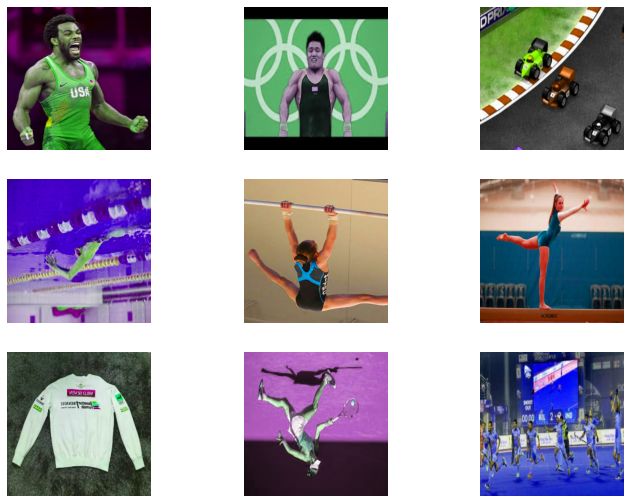

In [ ]:
# with augmentation
train, _ = get_data(
    data_path =DatasetConfig.DATA_ROOT, 
    batch_size=TrainingConfig.BATCH_SIZE, 
    size=224, transforms=True
)
visualize_from_batches(train)

11040


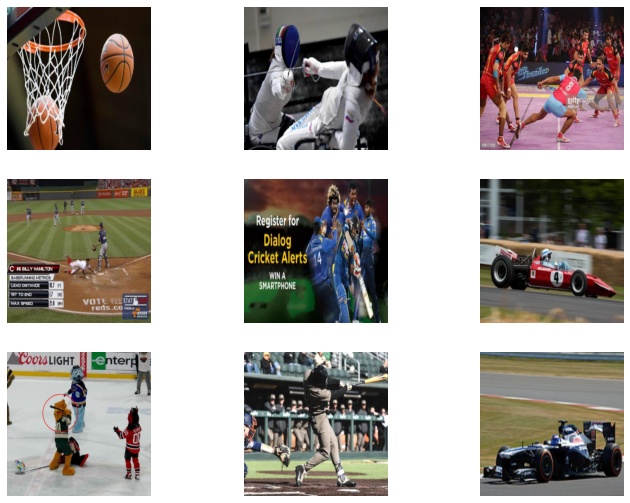

In [ ]:
# without augmentation
train, _ = get_data(
    data_path =DatasetConfig.DATA_ROOT, 
    batch_size=TrainingConfig.BATCH_SIZE, 
    size=224, transforms=False
)
visualize_from_batches(train)

## 4 Main Training Function

The following is the main training function. It:
* Creates the model.
* Prepares the data depending on whether we apply multi-resolution or not.
* Prepares the TensorBoard callback.
* Invikes the `fit()` method to train the model on the data.

In [ ]:
def train(model_name, optimizer, epochs, fixed_size, batch_size, 
          data_path, transforms, batch_norm, multi_resolution, dropout, phi, version):
    
    model=get_model()
    model.summary()
    

    callbacks = tf.keras.callbacks.TensorBoard(
        log_dir=f"logs/logs_{version}", histogram_freq=0, write_graph=True,
        write_images=False, write_steps_per_second=False, update_freq='epoch',
        profile_batch=2, embeddings_freq=0, embeddings_metadata=None
    )
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = 'accuracy', run_eagerly=True)


    train_gen, val_gen = get_data(
    data_path =DatasetConfig.DATA_ROOT, 
    batch_size=TrainingConfig.BATCH_SIZE, 
    size=256, transforms=True
)

    history = model.fit(
        train_gen,
        epochs=epochs,
        callbacks = [callbacks],
        validation_data=val_gen,
        verbose=1)
    model.save('sports.h5')     
    return history

## 5 Graph Plotting Function

The following `plot_loss_accuracy()` will help us plot the accuracy and loss plots efficiently.

In [ ]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors, model_sizes, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=11,
                       fig_size=(21, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = min(train_loss[i])
        
        min_val_loss = min(val_loss[i])
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="[{2}] TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i], model_sizes[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="[{2}] VALID ({0:.4}): {1}".format(min_val_loss, labels[i], model_sizes[i]))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = max(train_acc[i])
        
        max_val_acc = max(val_acc[i]) 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="[{2}] TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i], model_sizes[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="[{2}] VALID ({0:.4}): {1}".format(max_val_acc, labels[i], model_sizes[i]))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')
    
    plt.show(block=block_plot)
    
    return   

## 6 Training

In [ ]:
if __name__ == '__main__':
    optimizer = tf.keras.optimizers.Adam(learning_rate=TrainingConfig.learning_rate)

    # experiment 1
    version = 'Fully_Regularized'
    history_1 = train(
        model_name='efficienet-b0', optimizer=optimizer, fixed_size=256, 
        epochs=TrainingConfig.EPOCHS, batch_size=TrainingConfig.BATCH_SIZE, 
        data_path=DatasetConfig.DATA_ROOT, transforms=True, 
        multi_resolution=True, batch_norm=True, dropout=True, phi=0, version=version
    )

    plot_loss_accuracy(
    [history_1.history['loss']], 
    [history_1.history['val_loss']], 
    [history_1.history['accuracy']], 
    [history_1.history['val_accuracy']],
    labels=['No_Reg'], 
    colors=['blue'], 
    model_sizes=['Normal'], 
    loss_legend_loc='upper center', 
    acc_legend_loc='upper left'
     )



/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  UserWarning,


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Conv2D)             (None, 16, 16, 768)  590592      ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 256, 768)     0           ['embedding[0][0]']              
                                                                                                  
 class_token (ClassToken)       (None, 257, 768)     768         ['reshape[0][0]']            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
828/828 [==============================] - 547s 659ms/step - loss: 4.8647 - accuracy: 0.1527 - val_loss: 2.3416 - val_accuracy: 0.3234
Epoch 2/100
828/828 [==============================] - 537s 648ms/step - loss: 2.1640 - accuracy: 0.4035 - val_loss: 1.6394 - val_accuracy: 0.5389
Epoch 3/100
828/828 [==============================] - 537s 649ms/step - loss: 1.6933 - accuracy: 0.5412 - val_loss: 2.6375 - val_accuracy: 0.3098
Epoch 4/100
828/828 [==============================] - 543s 656ms/step - loss: 2.9200 - accuracy: 0.4774 - val_loss: 3.6085 - val_accuracy: 0.1214
Epoch 5/100
828/828 [==============================] - 546s 659ms/step - loss: 2.3727 - accuracy: 0.3374 - val_loss: 1.4794 - val_accuracy: 0.5734
Epoch 6/100
828/828 [==============================] - 541s 653ms/step - loss: 1.1835 - accuracy: 0.6499 - val_loss: 0.9994 - val_accuracy: 0.6866
Epoch 7/100
828/828 [==============================] - 535s 646ms/step - loss: 1.0264 - accuracy: 0.6963 - val_loss: 1

## 7 Conclusion
* First, experiment with different model sizes without any other regularization technique.
* Choose the smalles possible overfit model, then use different regularization techniques, optimizers and augmentaions.
* If results are not satisfactory, try mixing different regularization techniques until you find the best possible model that gives good validation results.